## Introduction
Finally we are going to train our atrium segmentation network

## Imports:

* pathlib for easy path handling
* torch for tensor handling
* pytorch lightning for efficient and easy training implementation
* ModelCheckpoint and TensorboardLogger for checkpoint saving and logging
* imgaug for Data Augmentation
* numpy for file loading and array ops
* matplotlib for visualizing some images
* Our dataset and model



In [4]:
from pathlib import Path

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt
import os

import sys
sys.path.append("../scripts/")
from dataset import CardiacDataset
from model import UNet

## Dataset Creation
We begin by defining the data augmentation pipeline for the training dataset. This includes random affine transformations such as scaling (zoom in/out) and rotation, as well as elastic deformations to improve generalization and robustness.


In [21]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15),
              rotate=(-45, 45)),
    iaa.ElasticTransformation()
])

Next, we instantiate the training and validation datasets using the `CardiacDataset` class. The training set receives the augmentation sequence, while the validation set remains unchanged.

In [22]:
# Create the dataset objects
train_path = Path("../data/Preprocessed/train/")
val_path = Path("../data/Preprocessed/val")

train_dataset = CardiacDataset(train_path, seq)
val_dataset = CardiacDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 1932 train images and 339 val images



We print out the total number of 2D slices used for training and validation, which represent the total number of individual axial images extracted from all subjects.

To verify the slice distribution, we iterate through each subject folder and count how many 2D slices were preprocessed and stored in each `slices/` directory. This gives us a detailed view of how many samples are contributed by each subject.

This step is useful to ensure the dataset was correctly preprocessed and to check for potential imbalances between subjects.

In [23]:
for subject in train_path.glob("*"):
    slices_path = subject / "slices"
    slices = list(slices_path.glob("*.npy"))
    print(f"{subject.name}: {len(slices)} slices found")

0: 130 slices found
1: 110 slices found
10: 122 slices found
11: 100 slices found
12: 110 slices found
13: 100 slices found
14: 110 slices found
15: 110 slices found
16: 120 slices found
2: 120 slices found
3: 130 slices found
4: 100 slices found
5: 120 slices found
6: 120 slices found
7: 120 slices found
8: 90 slices found
9: 120 slices found


We now create the training and validation dataloaders using a batch size of 8 and 4 worker processes. The training data is shuffled to improve generalization, while the validation data is kept in order.

In [26]:
batch_size = 8
num_workers = 0
persistent_workers = False

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


## Custom Loss
In medical image segmentation, the goal is to predict a mask that matches as closely as possible the true shape of the organ or structure. For this, we need a loss function that accurately measures how similar two binary masks are: the predicted one and the ground truth.

### Why not use Cross-Entropy?

Cross-Entropy is commonly used in classification tasks, but it treats each pixel independently. In segmentation, this often leads to poor performance when the object of interest (like the left atrium) occupies only a small part of the image — a situation known as **class imbalance**. The model might learn to predict "background" everywhere and still get a good loss.

### Why use Dice Loss?

Dice Loss is specifically designed to measure the **overlap between two binary masks**. It focuses directly on the match between the predicted mask and the ground truth.

The Dice Loss is based on the **Dice coefficient**, a metric from the field of set similarity:

$$
L(\hat{y}, y) = 1 - \frac{2 \cdot |\hat{y} \cap y|}{|\hat{y}| + |y|}
$$

Where:
- $\hat{y}$ is the predicted mask.
- $y$ is the ground truth mask.
- $\hat{y} \cap y$ is the number of pixels where both are 1 (true positives).
- $|\hat{y}|$ is the number of predicted foreground pixels.
- $|y|$ is the number of ground truth foreground pixels.

The Dice Loss ranges from 0 (perfect match) to 1 (no overlap). Since our goal is to maximize similarity, we minimize this loss.

### Why is it better for segmentation?

Dice Loss directly optimizes for **overlap**, which is exactly what we care about in segmentation. It is:
- Robust to class imbalance.
- Easy to compute.
- Closely aligned with how we evaluate segmentation quality in practice.

This makes it a strong choice for training models to segment small, complex structures like the left atrium.

In [10]:
class DiceLoss(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
                
        # Flatten label and prediction tensors
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        counter = (pred * mask).sum()  # Numerator       
        denum = pred.sum() + mask.sum() + 1e-8  # Denominator. Add a small number to prevent NANS
        dice =  (2*counter)/denum
        return 1 - dice


## Full Segmentation Model

This class wraps the full segmentation pipeline into a single PyTorch Lightning module.  
It includes:

- The U-Net architecture for left atrium segmentation.
- Dice Loss as the training objective, optimized for overlap-based evaluation.
- Adam optimizer with a fixed learning rate.
- Training and validation steps with automatic logging.
- Visual logging of predictions using TensorBoard every few batches.

The forward pass produces the predicted mask using a sigmoid activation, while training and validation steps compute the loss and optionally visualize predictions. PyTorch Lightning handles the optimization and backpropagation internally based on the returned loss.

In [9]:
class AtriumSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.model = UNet()  # Define the segmentation model (U-Net)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)  # Use Adam optimizer
        self.loss_fn = DiceLoss()  # Use Dice Loss for segmentation

    def forward(self, data):
        # Forward pass through the network with sigmoid activation
        return torch.sigmoid(self.model(data))

    def training_step(self, batch, batch_idx):
        # Unpack the batch
        mri, mask = batch
        mask = mask.float()  # Convert mask to float for Dice calculation

        # Forward pass
        pred = self(mri)

        # Compute Dice Loss
        loss = self.loss_fn(pred, mask)

        # Log training loss to TensorBoard
        self.log("Train Dice", loss)

        # Log sample images every 50 steps
        if batch_idx % 50 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Train")

        return loss  # Lightning will handle backward and optimization

    def validation_step(self, batch, batch_idx):
        # Unpack the batch
        mri, mask = batch
        mask = mask.float()

        # Forward pass
        pred = self(mri)

        # Compute Dice Loss
        loss = self.loss_fn(pred, mask)

        # Log validation loss
        self.log("Val Dice", loss)

        # Log images every 2 validation steps
        if batch_idx % 2 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Val")

        return loss

    def log_images(self, mri, pred, mask, name):
        # Convert predictions to binary mask
        pred = pred > 0.5

        # Create a side-by-side comparison plot
        fig, axis = plt.subplots(1, 2)

        # Ground truth mask overlay
        axis[0].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)

        # Predicted mask overlay
        axis[1].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0] == 0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6)

        # Send figure to TensorBoard
        plt.close(fig)
        self.logger.experiment.add_figure(name, fig, self.global_step)

    def configure_optimizers(self):
        # Return the optimizer to be used during training
        return [self.optimizer]

We now instantiate the training module and configure the PyTorch Lightning `Trainer`.

- We set a fixed random seed for reproducibility.
- We create a `ModelCheckpoint` callback to save the top 10 models based on validation Dice loss.
- The model is trained for up to 75 epochs using 1 GPU (if available).
- Logging is performed every step, and results are written to the `logs/` directory for visualization with TensorBoard.

Once configured, we call `trainer.fit()` to begin the training process.

In [29]:
# Instanciate the model and set the random seed
torch.manual_seed(0)
model = AtriumSegmentation()

In [18]:
from datetime import datetime
run_id = datetime.now().strftime("%Y%m%d-%H%M%S")
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Dice',
    save_top_k=10,
    mode='min',
    dirpath=f"../weights/{run_id}")


In [31]:
# Create the trainer
# Change the gpus parameter to the number of available gpus in your computer. Use 0 for CPU training

gpus = 1 #TODO
trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger(save_dir="../logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,max_epochs=75)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [32]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | UNet     | 7.8 M 
1 | loss_fn | DiceLoss | 0     
-------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Evaluation:

We begin by launching TensorBoard to visualize training logs and qualitative segmentation results.  
This helps us monitor training behavior and visually inspect model predictions over time.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ../logs

We import the necessary libraries for visualization (`nibabel`, `tqdm`, `celluloid`) and then load a pre-trained model checkpoint using `load_from_checkpoint`.

This loads the full model architecture and the trained weights from a given epoch.

In [6]:
import nibabel as nib
from tqdm.notebook import tqdm
from celluloid import Camera


In [11]:
model = AtriumSegmentation.load_from_checkpoint("../weights/1/epoch=72-step=17665.ckpt")

We set the model to evaluation mode (`model.eval()`) and send it to GPU if available.  
This ensures that no gradients are tracked during inference, saving memory and improving speed.

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval();
model.to(device);

We loop through the entire validation dataset and:
- Move each slice to the correct device
- Use `torch.no_grad()` to disable gradient computation
- Predict the mask using the trained model
- Store both the predicted and ground truth masks for later evaluation

The output predictions are thresholded to binary and converted to NumPy arrays for metric calculation.

In [14]:
preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).to(device).unsqueeze(0)
    with torch.no_grad():
        pred = model(slice)
    preds.append(pred.cpu().numpy())
    labels.append(label)
    
preds = np.array(preds)
labels = np.array(labels)

NameError: name 'val_dataset' is not defined

Finally, we compute the Dice Score across the entire validation set.  
This is done by comparing all predicted masks against their ground truth counterparts using the Dice loss function defined earlier.

The result gives a single number that summarizes segmentation quality across all slices. A Dice Score close to 1 indicates excellent overlap between predicted and actual masks.

In [38]:
1-model.loss_fn(torch.from_numpy(preds), torch.from_numpy(labels))  # two possibilities

tensor(0.9268)

In [39]:
dice_score = 1-DiceLoss()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(f"The Val Dice Score is: {dice_score}")

The Val Dice Score is: 0.9268273115158081


## Visualization on an Unlabeled Test Subject

To qualitatively assess the model's performance, we apply it to a test MRI scan from the challenge dataset that was not used during training.

The steps are as follows:

- Load the full 3D MRI scan.
- Apply the same preprocessing as used during training (Z-normalization and standardization).
- Crop 32 pixels from the borders to match the training preprocessing.
- Slice the 3D volume along the sagittal axis and pass each 2D slice through the trained model.
- Threshold the output to obtain binary predictions.
- Visualize the prediction as an overlay on each slice using `celluloid` to generate an animated view of the segmentation across the entire scan.


(256, 256, 140)


C:\Users\demonki\anaconda3\envs\pytorchenv\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\demonki\anaconda3\envs\pytorchenv\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


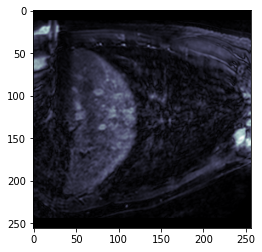

In [15]:
subject = Path("../data/Task02_Heart/imagesTs/la_002.nii.gz")
subject_mri = nib.load(subject).get_fdata()

# Helper functions for normalization and standardization
def normalize(full_volume):
    """
    Z-Normalization of the whole subject
    """
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized_data):
    """
    Standardize the normalized data into the 0-1 range
    """
    standardized_data = (normalized_data - normalized_data.min()) / (normalized_data.max() - normalized_data.min())
    return standardized_data


subject_mri = subject_mri[32:-32, 32:-32]
standardized_scan = standardize(normalize(subject_mri))

print(standardized_scan.shape)

preds = []
for i in range(standardized_scan.shape[-1]):
    slice = standardized_scan[:,:,i]
    with torch.no_grad():
        pred = model(torch.tensor(slice).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
        pred = pred > 0.5
    preds.append(pred.cpu())

fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(standardized_scan.shape[-1]):
    plt.imshow(standardized_scan[:,:,i], cmap="bone")
    mask = np.ma.masked_where(preds[i]==0, preds[i])
    plt.imshow(mask, alpha=0.5, cmap="autumn")
    
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation




from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video


Congratulations! You made it to the end of the segmentation lecture